# Experimental Modelling Notebook:

Import Packages:

In [48]:
# Data Parsing imports:
import pandas as pd
import numpy as np
import json
from collections import Counter
import re
import sys
import nltk
import time

# Preprcoessing imports:
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import spacy
#nltk.download('stopwords')
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

# Visualisation imports:
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
pio.renderers.default = "svg"

# Modelling Imports
import mlflow 
from sklearn.model_selection import cross_val_score
from mlflow.tracking import MlflowClient
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

# Local imports
sys.path.append("/Users/tajsmac/Documents/Sentiment-Analysis/")
from Scripts.data_parsing import remove_stop_words, remove_punctuation

In [3]:
# Store mlruns information on sqlite backend.
mlflow.set_tracking_uri("sqlite:///mlflow.db")
#If experiment doesn't already exist, then create it. 
exp_name = "Sentiment Analysis"
mlflow_exps = [exp._name for exp in mlflow.search_experiments()]
if exp_name not in mlflow_exps:
    mlflow.create_experiment(exp_name)
# Set experiment
mlflow.set_experiment(exp_name)
print("MlFlow Ready! :)")

MlFlow Ready! :)


Read in Data:

In [4]:
data_path = "/Users/tajsmac/Documents/Sentiment-Analysis/data/reviews.json"

In [5]:
with open(data_path, 'rb') as f:
    data = json.load(f)

Format data into Dataframe:

In [6]:
print(data.keys())

dict_keys(['positive_reviews', 'negative_reviews', 'neutral/constructive_reviews'])


In [7]:
data_dfs = []
for label, reviews_list in data.items():
    num_data_points = len(reviews_list)
    sub_df = pd.DataFrame({"Review" : reviews_list, "Sentiment" : [label] * num_data_points})
    data_dfs.append(sub_df)

reviews_df = pd.concat(data_dfs, axis=0)


## EDA:

In [8]:
reviews_df.head()

,Review,Sentiment
0,"Impressively accurate, answered my questions.",positive_reviews
1,"Helpful responses, provided valuable information.",positive_reviews
2,"Quick and reliable, saved me time.",positive_reviews
3,"Great assistance, exceeded expectations.",positive_reviews
4,"Informative and responsive, very useful.",positive_reviews


In [9]:
reviews_df.shape
print(f"Number of Datapoints: {reviews_df.shape[0]}")

Number of Datapoints: 393


In [10]:
reviews_df.loc[reviews_df.duplicated() == 1]

,Review,Sentiment
76,"Quick and reliable, saved me time.",positive_reviews
79,"Great assistance, exceeded expectations.",positive_reviews
82,"Accurate and efficient, highly recommended.",positive_reviews
94,"Reliable and helpful, exceeded expectations.",positive_reviews
119,"Inaccurate often, needs upgrades.",negative_reviews


In [11]:
reviews_df.drop_duplicates(inplace=True)

In [12]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 0 to 119
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     388 non-null    object
 1   Sentiment  388 non-null    object
dtypes: object(2)
memory usage: 9.1+ KB


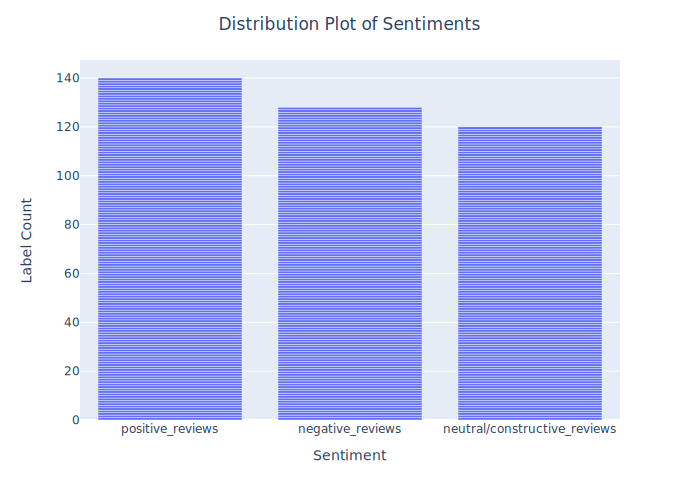

In [13]:
fig_label_dist = px.bar(reviews_df, x="Sentiment")
fig_label_dist.update_layout(yaxis=dict(title="Label Count"), title=dict(text="Distribution Plot of Sentiments", x=0.5))
fig_label_dist.show()

For NLP tasks in particular the feature engineering is important. A small list of tasks:

- Source a package which will provide a list of stop words. Stop words are a set of words which are commonly used and don't give much predictive ability. For example "The" doesn't tell us anything about the review. It could be "The bot was great" or "The chatbot is useless". Ideally we want to be left with words/features that provide an idea of what the label for the class is.
- Create a wordcloudb
- From each review, remove the stop words so only the "meaningful" words remain. 
- Vectorize the remaining words somehow. 
- Maybe generate a few more features? Number of characters in a review, number of "positive" words, number of "negative" words. 
- Train a model, log metrics, parameters with MlFlow. 
- Figure out best model and build training pipeline with Prefect. 

In [14]:
stop_words = set(STOPWORDS)

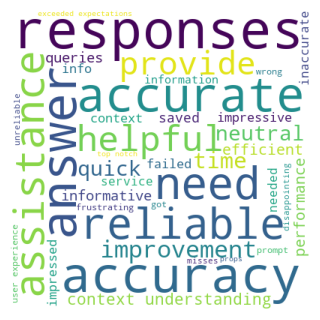

In [15]:
topwords = set(STOPWORDS)
comment_words = ''
# iterate through the csv file
for val in reviews_df["Review"]:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 400, height = 400,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (3, 3), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

Modelling Note: Bag of Words vs Something else?

- We used the bag words argument already in our original chatbot to classify questions into categories. However thinking about it now, we know that if a sentence comes in with words that aren't in the original corpus, then our vectorized form of this sentence is just a series of 0's. 
- This is quite bad in the event that we don't have a large training set that covers the possible "key" words needed for classification. For example if "Great" wasn't in our training set, but "This is good" was and someone reviewed: "This is great" our model just wouldn't do anything interesting. 
- This is where more interesting NLP techniques should be used. Think of the set of colours; each has an RGB encoding, this means similar colours will have a similar RGB encoding. Can we do the same thing for words? "Good" and "Great" are quite similar in meaning so if "Great" isn't in our training set, can we still associate it to "Good" which is in our training set and create a vector based on the similarity? 

The above is the idea we'll use to build a slightly more advanced model than a "bag of words". 

### Context Approach to Words:

- One way of trying to relate meaning of words to each other it to consider the context they are used in. For example consider: "it was a great time, it was a good time". One can build a vector representation of words like so:

    - Create a dataset with column headers as possible triplet combinations and initial column being the set of words in a corpus. Eg: the 4th column will be "a ___ time" and the vector for the word "great" would have 1 in the 4th column and so would be the word "Good" as "a good time" and "a great time" both appear in our sentence.
    - Thus because they would have the same vector, implying a similar meaning. 
    - However we if instead of "great" we has "worst" these vectors would still have the same representation so it's not necessarily that these words have the same meaning, but the fact they are closer in context. 
    - Repeating this idea in a large corpus can create vector representations of words where a smaller euclidean distance implies a similar context. 

- This idea can become complex with a larger corpus. You may also want to consider N-Grams, ie 3 or 4 combination of words, removing STOPWORDS, lemmatisation. 
- Given then additional dimensions that can be produced we can use a dimension reduction to obtain a lower dimensional representation of words. 
- Remember PCA or any other Dimension reduction, will reduce the dimensionality, ie the size of the vector representation but will still allow us to compare distances. 

Thankfully there are tools out there which provide a vector representation of words for us; that way we can easily compare distances between words to try and grasp their meaning/context.

Maybe a naive idea; but thinking out loud, we can generate vector representations for the words in our corpus. (Corpus being our set of reviews), when we recieve a review where key words don't match with key words in our corpus, then we can find the keywords in our datapoint that are closest in context to the words in our corpus and try to make an inference based on that vector. Or we can say if words are within a certain distance then we can argue they have the same meaning. For now we still need to develop an understanding of how opposite words are distinguished. 

Remark: In a higher dimensional space, better to use cosine similarity than the euclidean distance as a measure of how alike 2 vectors are.
Remark: We can obtain vector representations of sentences by taking an average of the embeddings for each word.

### Word2Vec Approach:

- The word2vec approach is a predictive approach to building word embeddings. A word embedding is a vector representation of a word. 
- Find linked here a video showing how word2vec is built. [Word2Vec-Video](https://www.youtube.com/watch?v=UqRCEmrv1gQ&t)

We have 2 different approaches here in word2vec to obtain word embeddings. Both models take the same initial steps:
    - Creating a vocabulary of the words in a corpus.
    - Creating one-hot encoded vectors for each word. 

- CBOW - Continuous bag of words:
    - Takes a window of fixed length and passing through our corpus, we will generate training data as the words surrounding the center word and the label will be the center word. Eg: if our window is of size 1 (meaning 1 word on both sides of center), we may have "best tasting food", training dataset = "best __ food", label="tasting". 
    - The precise architecture can be found in the video but the basic idea is each training datapoint is converted into their respective one-hot encoded vectors. Then the same matrix is applied to each one-hot encoded vector to generate another series of vectors, from which we take the sum to form another vector. This hidden layer vector is then fed forward to the output layer which after softmax predicts the one-hot encoded vector of the label. 
    - The final weight matrix when transitioning from each input to the first hidden layer is always the same. 

- Skipgram:
    - Skipgram model similarly applies a window across the corpus, but the training datapoint is the predictive word in the window, eg: from previous example can be "tasting" 
      and the label will be the remaining context words in the window, in our case: "best", "food". 
    - The final weight matrix on each arrow of the Skipgram model is the same. 

Once both models are trained, we can generate word embeddings use the weight matrices. 

- In the CBOW case, the initial matrix that is applied to the context words is applied to a one-hot encoded vector of the word we want a work embedding for. This generates a vector with length equal to number of neurons in the hidden layer. This is the word embedding. 

- In the Skipgram model we apply the initial matrix when moving from input layer to hidden layer to a one-hot encoded vector of the word we want an embedding for. Similarly this generates a vector with length equal to number of neurons in the hidden layer. This is our word embedding. 


<img src="../Graphics/Word2Vec.png" alt="drawing" width="600" height="350"/>

The purpose of this was to build familiarity on word embeddings and how we can use them to build more sophisticated models than a "bag of words". Although the latter is still yet to come - progress has been made. :) 

## Further EDA:

An intuitive idea is whether character length has an impact on classification/label. I would imagine negative reviews tend to be longer. To this end, I'll create a distribution plot of character length to see if it's worth using as a feature:

In [16]:
# Add character length column:
reviews_df["Review_Length"] = reviews_df["Review"].apply(lambda x: len(x))

In [17]:
reviews_df.head()

,Review,Sentiment,Review_Length
0,"Impressively accurate, answered my questions.",positive_reviews,45
1,"Helpful responses, provided valuable information.",positive_reviews,49
2,"Quick and reliable, saved me time.",positive_reviews,34
3,"Great assistance, exceeded expectations.",positive_reviews,40
4,"Informative and responsive, very useful.",positive_reviews,40


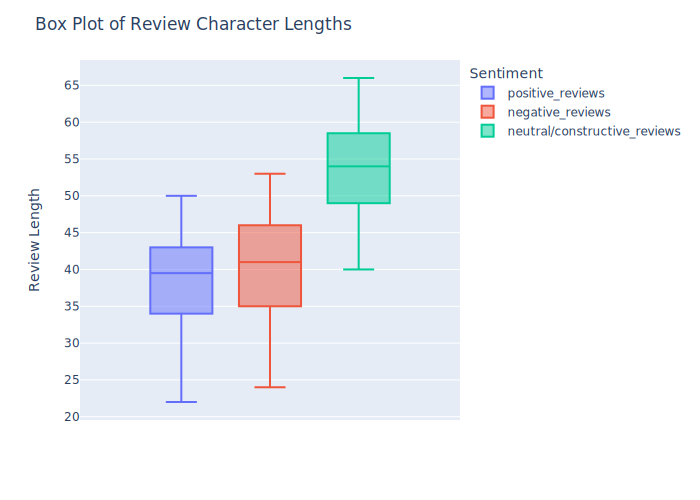

In [18]:
char_length_fig = px.box(reviews_df, y="Review_Length", color="Sentiment")
char_length_fig.update_layout(title="Box Plot of Review Character Lengths", yaxis=dict(title="Review Length"))
char_length_fig.show()

As I want my model to flag when reviews of my website chatbot are consistently negative/neutral; I will turn this multiclass problem into a binary classification problem. Furthermore, given that I think more people will choose to give constructive feedback than just completely negative, it makes sense to consider the number of characters as a feature. 

In [19]:
# Merge netural/constructive reviews and negative_reviews into one class. 
conditions = [(reviews_df["Sentiment"] == "positive_reviews"), (reviews_df["Sentiment"] == "negative_reviews"), (reviews_df["Sentiment"] == "neutral/constructive_reviews")]
outputs = [1, 0, 0]
reviews_df["Binary_Sentiment"] = np.select(conditions, outputs)

In [20]:
reviews_df.head()

,Review,Sentiment,Review_Length,Binary_Sentiment
0,"Impressively accurate, answered my questions.",positive_reviews,45,1
1,"Helpful responses, provided valuable information.",positive_reviews,49,1
2,"Quick and reliable, saved me time.",positive_reviews,34,1
3,"Great assistance, exceeded expectations.",positive_reviews,40,1
4,"Informative and responsive, very useful.",positive_reviews,40,1


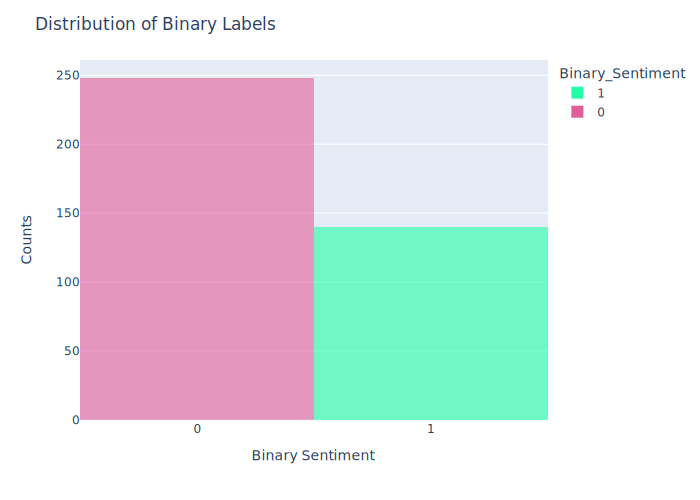

In [21]:
binary_class_fig = px.histogram(reviews_df, x="Binary_Sentiment",color="Binary_Sentiment", color_discrete_sequence=[ "#22FFA7","#E15F99",], opacity=0.6)
binary_class_fig.update_layout(title="Distribution of Binary Labels", 
                               xaxis=dict(title="Binary Sentiment", tick0=0, dtick=1, tickmode="linear"),
                               yaxis=dict(title="Counts"))
binary_class_fig.show()

Frequent Word Analysis by Class:

In [22]:
# First lets remove punctuation. 
reviews_df["Only_Words"] = reviews_df["Review"].str.replace('[^a-zA-Z]', ' ')


/var/folders/bn/m0fctgmn5t753x60khg3_q2m0000gn/T/ipykernel_1372/486362116.py:2: FutureWarning:

The default value of regex will change from True to False in a future version.



In [23]:
reviews_df.head()

,Review,Sentiment,Review_Length,Binary_Sentiment,Only_Words
0,"Impressively accurate, answered my questions.",positive_reviews,45,1,Impressively accurate answered my questions
1,"Helpful responses, provided valuable information.",positive_reviews,49,1,Helpful responses provided valuable information
2,"Quick and reliable, saved me time.",positive_reviews,34,1,Quick and reliable saved me time
3,"Great assistance, exceeded expectations.",positive_reviews,40,1,Great assistance exceeded expectations
4,"Informative and responsive, very useful.",positive_reviews,40,1,Informative and responsive very useful


In [24]:
positive_reviews = set(reviews_df.loc[reviews_df["Binary_Sentiment"] == 1]["Only_Words"])
negative_reviews = set(reviews_df.loc[reviews_df["Binary_Sentiment"] == 0]["Only_Words"])

In [25]:
all_positive_words = " ".join(positive_reviews)
all_negative_words = " ".join(negative_reviews)

pos_words_split = all_positive_words.split()
neg_words_split = all_negative_words.split()

pos_words_split = [word.lower() for word in pos_words_split]
neg_words_split = [word.lower() for word in neg_words_split]

# Need to remove stop words:
english_stop_words = set(stopwords.words("english"))
pos_no_stop_words = [word for word in pos_words_split if word not in english_stop_words]
neg_no_stop_words = [word for word in neg_words_split if word not in english_stop_words]

pos_words_counter = Counter(pos_no_stop_words)
neg_words_counter = Counter(neg_no_stop_words)

print(pos_words_counter)

Counter({'reliable': 28, 'accurate': 25, 'helpful': 23, 'assistance': 22, 'quick': 18, 'efficient': 17, 'informative': 15, 'impressive': 14, 'saved': 14, 'exceeded': 13, 'performance': 12, 'time': 12, 'provided': 12, 'prompt': 11, 'info': 10, 'expectations': 10, 'props': 9, 'top': 9, 'notch': 9, 'great': 9, 'needs': 8, 'impressed': 8, 'made': 8, 'responsive': 8, 'highly': 7, 'recommended': 7, 'service': 7, 'valuable': 7, 'insights': 7, 'answers': 6, 'tried': 6, 'excellent': 6, 'tasks': 6, 'met': 5, 'thumbs': 5, 'user': 5, 'friendly': 5, 'well': 5, 'got': 4, 'easy': 4, 'support': 4, 'pretty': 4, 'information': 4, 'job': 4, 'solid': 4, 'easier': 4, 'useful': 4, 'rocking': 3, 'tool': 3, 'answered': 3, 'buddy': 3, 'simpler': 3, 'knows': 3, 'needed': 3, 'responses': 3, 'effective': 3, 'loving': 3, 'precise': 2, 'fuss': 2, 'worth': 2, 'help': 2, 'finding': 2, 'cool': 2, 'satisfied': 2, 'thing': 2, 'stuff': 2, 'effort': 2, 'giving': 2, 'accuracy': 2, 'questions': 2, 'hassle': 2, 'free': 2, 'f

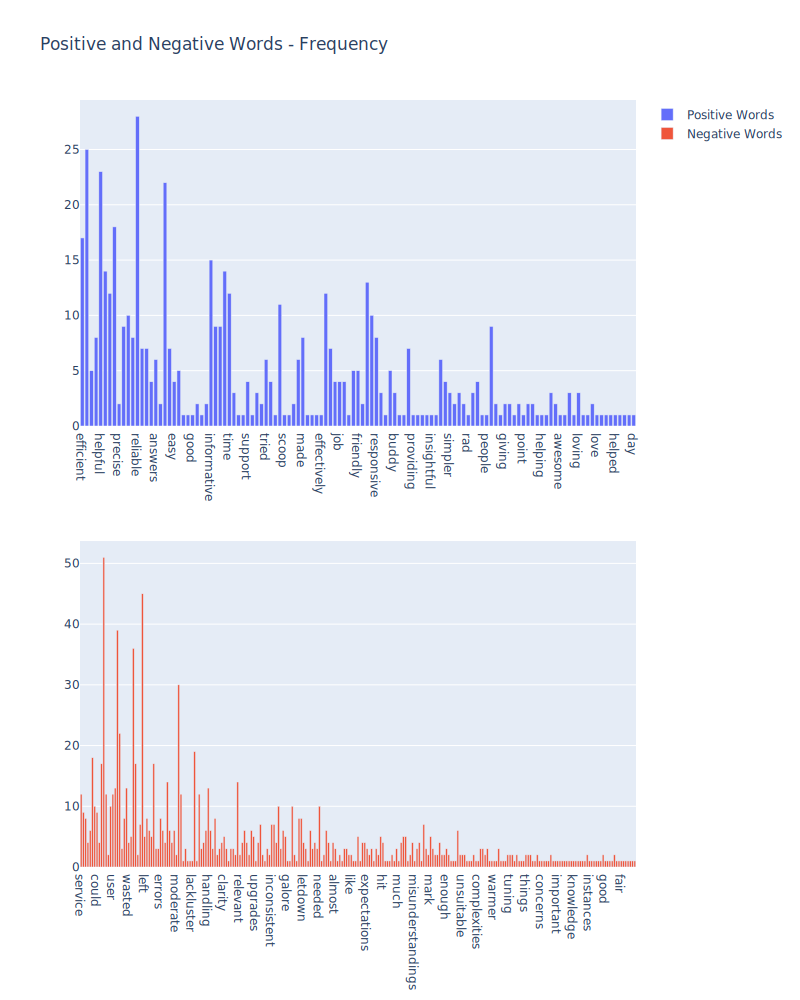

In [26]:
frequency_words_fig = make_subplots(rows=2, cols=1)
frequency_words_fig.add_trace(go.Bar(x=list(pos_words_counter.keys()), y=list(pos_words_counter.values()), name="Positive Words"), row=1, col=1)
frequency_words_fig.add_trace(go.Bar(x=list(neg_words_counter.keys()), y=list(neg_words_counter.values()), name="Negative Words"), row=2, col=1)
frequency_words_fig.update_layout(title="Positive and Negative Words - Frequency", width=800, height=1000) 

In [27]:
both_pos_neg_words = set(pos_no_stop_words).intersection(set(neg_no_stop_words))
print(f"Number of words in both positive and negative reviews: {len(both_pos_neg_words)}")
print(both_pos_neg_words)

Number of words in both positive and negative reviews: 39
{'knowledge', 'assistance', 'handled', 'things', 'impressed', 'pretty', 'accurate', 'performance', 'well', 'stuff', 'made', 'experience', 'information', 'point', 'effectively', 'info', 'got', 'helpful', 'precise', 'recommended', 'responses', 'trying', 'time', 'expectations', 'needed', 'good', 'help', 'queries', 'provided', 'accuracy', 'reliable', 'way', 'insights', 'user', 'service', 'questions', 'worth', 'needs', 'answers'}


We can see that even after removing stopwords, we still have a fair few words that are in both positive and negative reviews. We essentially want to keep words that help our model to differentiate between positive and negative reviews. Words like "time", "made", "got", "info" - intuitavely don't have much benefit. However we will keep them in our training dataset for now but make note of it here as a potential model improvement. 

## Preprocessing:

In [28]:
# remove stopwords and punctuation:
reviews_df.head()

,Review,Sentiment,Review_Length,Binary_Sentiment,Only_Words
0,"Impressively accurate, answered my questions.",positive_reviews,45,1,Impressively accurate answered my questions
1,"Helpful responses, provided valuable information.",positive_reviews,49,1,Helpful responses provided valuable information
2,"Quick and reliable, saved me time.",positive_reviews,34,1,Quick and reliable saved me time
3,"Great assistance, exceeded expectations.",positive_reviews,40,1,Great assistance exceeded expectations
4,"Informative and responsive, very useful.",positive_reviews,40,1,Informative and responsive very useful


In [29]:
reviews_df["Review_No_Stop_Words"] = reviews_df["Only_Words"].apply(remove_stop_words)

In [30]:
reviews_df.head()

,Review,Sentiment,Review_Length,Binary_Sentiment,Only_Words,Review_No_Stop_Words
0,"Impressively accurate, answered my questions.",positive_reviews,45,1,Impressively accurate answered my questions,impressively accurate answered questions
1,"Helpful responses, provided valuable information.",positive_reviews,49,1,Helpful responses provided valuable information,helpful responses provided valuable information
2,"Quick and reliable, saved me time.",positive_reviews,34,1,Quick and reliable saved me time,quick reliable saved time
3,"Great assistance, exceeded expectations.",positive_reviews,40,1,Great assistance exceeded expectations,great assistance exceeded expectations
4,"Informative and responsive, very useful.",positive_reviews,40,1,Informative and responsive very useful,informative responsive useful


In [31]:
nlp = spacy.load("en_core_web_md")

embeddings_mat = pd.DataFrame(reviews_df.apply
                              (lambda row : nlp(row["Review_No_Stop_Words"]).vector, 
                               axis=1).tolist())
embeddings_mat["Binary_Sentiment"] = reviews_df["Binary_Sentiment"].to_numpy()

In [32]:
reviews_df.head()

,Review,Sentiment,Review_Length,Binary_Sentiment,Only_Words,Review_No_Stop_Words
0,"Impressively accurate, answered my questions.",positive_reviews,45,1,Impressively accurate answered my questions,impressively accurate answered questions
1,"Helpful responses, provided valuable information.",positive_reviews,49,1,Helpful responses provided valuable information,helpful responses provided valuable information
2,"Quick and reliable, saved me time.",positive_reviews,34,1,Quick and reliable saved me time,quick reliable saved time
3,"Great assistance, exceeded expectations.",positive_reviews,40,1,Great assistance exceeded expectations,great assistance exceeded expectations
4,"Informative and responsive, very useful.",positive_reviews,40,1,Informative and responsive very useful,informative responsive useful


In [33]:
embeddings_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Binary_Sentiment
0,0.887417,0.374524,0.195575,0.849393,2.867118,0.787600,1.317718,3.693925,-3.228225,-0.728190,...,-1.537925,0.119875,-1.870734,0.606220,-0.300270,0.854828,-1.084487,-3.264627,0.879478,1
1,1.247498,-2.280848,-0.498794,-0.357650,3.782720,-1.635408,0.129476,2.031170,-3.687460,-0.864662,...,-1.594186,0.302082,0.346272,0.716666,-0.245880,-0.018786,-2.785760,-2.104215,1.717742,1
2,0.588148,0.804627,-0.739107,1.080475,4.562250,-0.234535,2.779623,1.304208,-0.659753,0.190742,...,-1.214355,0.674773,0.370480,-0.920200,1.315548,-0.209330,-1.688770,-1.431650,0.869047,1
3,-0.538958,-1.227485,-2.828349,0.204670,2.103775,-0.759675,1.491190,3.541962,-0.735098,-1.505667,...,-0.146835,-0.825350,-0.655100,-0.983767,0.510150,-0.972080,-0.333912,-3.916018,2.345790,1
4,1.329927,-0.295700,-0.643353,0.172013,3.357100,-1.091982,0.617607,1.697833,-4.458967,-0.463513,...,-2.006433,0.017443,-0.812827,0.661033,-1.031477,1.262826,-2.298700,-4.098933,1.569560,1


Lets run a PCA plot to reduce the number of features and see if our projected features are seperable. This might give us an indication of whether a model is viable.

In [34]:
X = embeddings_mat.drop(columns=["Binary_Sentiment"])
y = embeddings_mat["Binary_Sentiment"]

# Fitting PCA:
time_1 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=20).fit_transform(X.values)
time_2 = time.time()
time_taken = time_2 - time_1
print(f"PCA Fitted: {time_taken :2f}s")

PCA Fitted: 0.079286s


In [35]:
X_reduced_pca_df = pd.DataFrame(X_reduced_pca, columns=["Component 1", "Component 2"])
X_reduced_pca_df = X_reduced_pca_df.join(embeddings_mat["Binary_Sentiment"])

In [36]:
X_reduced_pca_df.head()

,Component 1,Component 2,Binary_Sentiment
0,-1.853031,-1.643352,1
1,-11.192205,2.993547,1
2,6.211666,6.245893,1
3,-5.989240,0.511754,1
4,-7.587274,6.544717,1


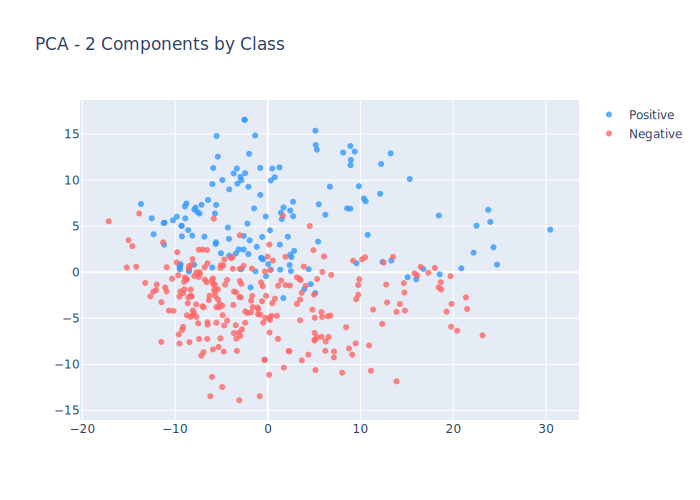

In [37]:
pos_df = X_reduced_pca_df.loc[X_reduced_pca_df["Binary_Sentiment"] == 1]
neg_df = X_reduced_pca_df.loc[X_reduced_pca_df["Binary_Sentiment"] == 0]


pca_plot = go.Figure(go.Scatter(x=pos_df["Component 1"], 
                                y=pos_df["Component 2"],
                                mode="markers",
                                marker_color='rgba(51, 153, 255, .8)',
                                name="Positive"))
pca_plot.add_trace(go.Scatter(x=neg_df["Component 1"],
                              y=neg_df["Component 2"], 
                              mode="markers",
                              marker_color='rgba(255, 102, 102, .8)', 
                              name="Negative"))

pca_plot.update_layout(title="PCA - 2 Components by Class")

pca_plot.show()

Given these points after PCA are almost linearly seperable, this suggests it is likely these points are seperable in higher dimensions.

Given after using Spacy word embeddings, we have 300 features, I consider using PCA to reduce the number of features. Though unclear how many components we want to use. Lets plot explained variance against number of components to determine an "ideal" number of features to reduce to.

In [38]:
a = PCA(n_components=2, random_state=20).fit(X.values)
print(a.explained_variance_ratio_.sum())

0.26871008


In [39]:
explained_vars = {}
max_comp = 100
# Max set to 100 as don't want to use anymore than 100 anyways.
pca = PCA(n_components=max_comp, random_state=20).fit(X.values)
for comp in range(1, max_comp):
    explained_vars[comp] = pca.explained_variance_ratio_[:comp].sum()

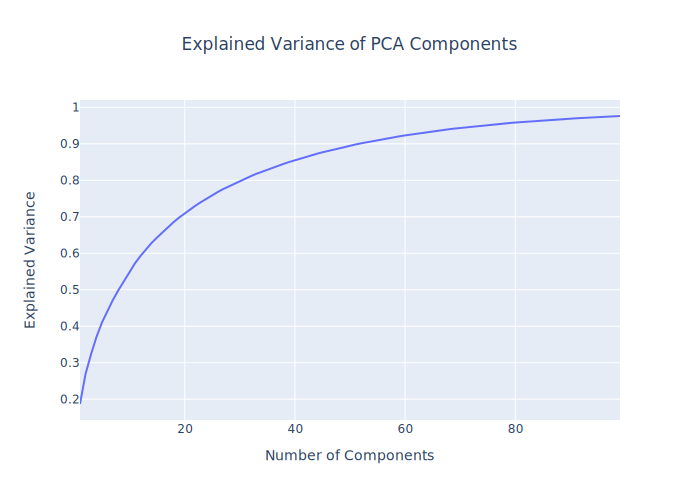

In [40]:
pca_var_plot = go.Figure(go.Scatter(x=list(explained_vars.keys()),
                                    y=list(explained_vars.values())))

pca_var_plot.update_layout(title={"text" : "Explained Variance of PCA Components",
                                  "x" : 0.5},
                            xaxis_title="Number of Components", 
                            yaxis_title="Explained Variance")
pca_var_plot.show()

I'll use PCA to reduce the number of features down to 40. According to our plot, we will maintain an explainability percentage of around 85%. 

## Model Training:

In [41]:
embeddings_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Binary_Sentiment
0,0.887417,0.374524,0.195575,0.849393,2.867118,0.787600,1.317718,3.693925,-3.228225,-0.728190,...,-1.537925,0.119875,-1.870734,0.606220,-0.300270,0.854828,-1.084487,-3.264627,0.879478,1
1,1.247498,-2.280848,-0.498794,-0.357650,3.782720,-1.635408,0.129476,2.031170,-3.687460,-0.864662,...,-1.594186,0.302082,0.346272,0.716666,-0.245880,-0.018786,-2.785760,-2.104215,1.717742,1
2,0.588148,0.804627,-0.739107,1.080475,4.562250,-0.234535,2.779623,1.304208,-0.659753,0.190742,...,-1.214355,0.674773,0.370480,-0.920200,1.315548,-0.209330,-1.688770,-1.431650,0.869047,1
3,-0.538958,-1.227485,-2.828349,0.204670,2.103775,-0.759675,1.491190,3.541962,-0.735098,-1.505667,...,-0.146835,-0.825350,-0.655100,-0.983767,0.510150,-0.972080,-0.333912,-3.916018,2.345790,1
4,1.329927,-0.295700,-0.643353,0.172013,3.357100,-1.091982,0.617607,1.697833,-4.458967,-0.463513,...,-2.006433,0.017443,-0.812827,0.661033,-1.031477,1.262826,-2.298700,-4.098933,1.569560,1


In [42]:
X = embeddings_mat.drop(columns=["Binary_Sentiment"])
y = embeddings_mat["Binary_Sentiment"]

In [43]:
X_reduced_40_comp = PCA(n_components=40, random_state=40).fit_transform(X.values)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced_40_comp, y, random_state=55,
                                                    test_size=0.2)

print(f"Training set Size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set Size: 310
Test set size: 78


In [45]:
rand_state = 42

# Logistic Regression - penality being norm of error, C being value of regularization strength. (Lower => more cost for complex parameters.)
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

log_reg_grid = GridSearchCV(LogisticRegression(solver="liblinear"), log_reg_params)
log_reg_grid.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg_model = log_reg_grid.best_estimator_
print("Logistic Regression Model Trained")    


# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
svc_grid = GridSearchCV(SVC(), svc_params)
svc_grid.fit(X_train, y_train)

# SVC best estimator
svc_model = svc_grid.best_estimator_
print("SVM Model Trained")


# Random Forest Classifier
rf_params = {"max_depth": list(range(2,7,1)), "min_samples_leaf": list(range(2,7,1)),
             "random_state" : [rand_state]}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_params)
rf_grid.fit(X_train, y_train)

# best tree estimator
tree_model = rf_grid.best_estimator_
print("Random Forest Trained")

#Extra Trees Classifier
et_params = {"n_estimators" : list(range(100,500,50)), "max_features" : [10, "sqrt", "log2"], 
             "random_state" : [rand_state]}
et_grid = GridSearchCV(ExtraTreesClassifier(), et_params)
et_grid.fit(X_train, y_train)

#best extra trees classifier
et_model = et_grid.best_estimator_
print("Extra Trees Trained")

Logistic Regression Model Trained
SVM Model Trained
Random Forest Trained
Extra Trees Trained


Now that we've trained our models, we want to log what we've tried with MlFlow. 

In [46]:
num_folds = 6
models_hyperparams_searched = {"Logistic Regression" : log_reg_params,
                               "Support Vector Machine" : svc_params,
                               "Random Forest" : rf_params, 
                               "Extra Trees" : et_params}

models_tags = {"Logistic Regression" : "linear",
               "Support Vector Machine" : "linear", 
               "Random Forest" : "ensemble", 
               "Extra Trees" : "ensemble"}

models_dict = {"Logistic Regression" : [LogisticRegression(**log_reg_grid.best_params_), log_reg_grid.best_params_], 
               "Support Vector Machine" : [SVC(**svc_grid.best_params_), svc_grid.best_params_],
               "Random Forest" : [RandomForestClassifier(**rf_grid.best_params_), rf_grid.best_params_],
               "Extra Trees" : [ExtraTreesClassifier(**et_grid.best_params_), et_grid.best_params_]}

for model_type, (model, hyperparams) in models_dict.items():
    with mlflow.start_run(run_name=model_type):
        # Fitting/computing metrics
        model.fit(X_train, y_train)
        cv_score = cross_val_score(model, X_train, y_train, cv=num_folds).mean().round(3)
        predicted_y_test = model.predict(X_test)
        test_accuracy = accuracy_score(predicted_y_test, y_test).round(3)
        searched_params = models_hyperparams_searched[model_type]
        model_tag = models_tags[model_type]

        # log model hyperparams and metrics with mflow. 
        mlflow.log_params(hyperparams)
        mlflow.log_param("Random State", rand_state)
        mlflow.set_tag("model_type", model_tag)
        mlflow.log_param("Grid Searched Params", searched_params)
        mlflow.log_metric("Cross Validation Score", cv_score)
        mlflow.log_metric("Test Accuracy", test_accuracy)
        mlflow.sklearn.log_model(model, f"{model_type} - Model")

        print(f"{model_type}: Cross Validation Score: {cv_score}")
        print(f"{model_type}: Test Accuracy: {test_accuracy}")
        print("----" * 15)


/Users/tajsmac/opt/miniconda3/envs/sentiment_analysis/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Setuptools is replacing distutils.



Logistic Regression: Cross Validation Score: 0.968
Logistic Regression: Test Accuracy: 0.974
------------------------------------------------------------
Support Vector Machine: Cross Validation Score: 0.955
Support Vector Machine: Test Accuracy: 0.974
------------------------------------------------------------
Random Forest: Cross Validation Score: 0.894
Random Forest: Test Accuracy: 0.923
------------------------------------------------------------
Extra Trees: Cross Validation Score: 0.923
Extra Trees: Test Accuracy: 0.974
------------------------------------------------------------


Here we can see all trained models are logged, with the metrics and the training times.

![alternatvie text](../Graphics/Trained_Models_Mlflow.png)

I've also logged the parameters that have been searched during the GridSearch:

![alternatvie text](../Graphics/HyperParams_Logged.png)

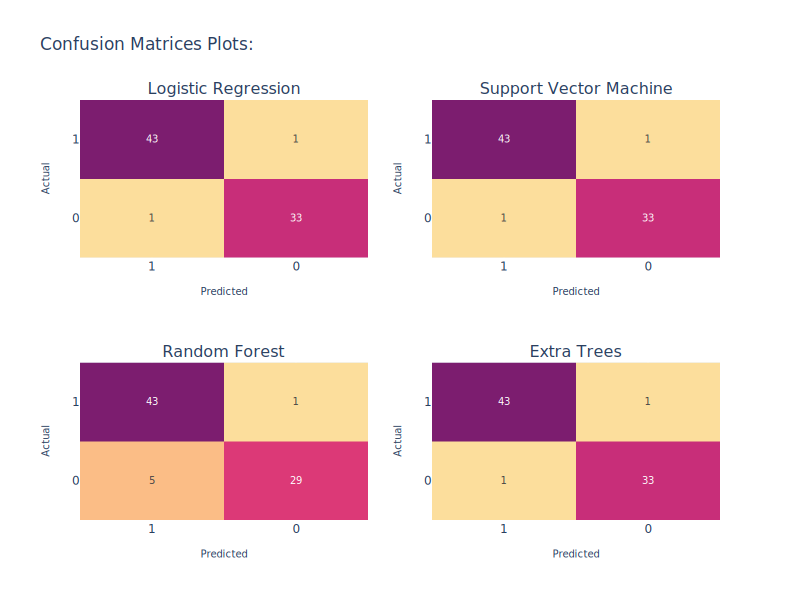

In [47]:
confusion_matrix_plot = make_subplots(rows=2, cols=2,
                                    subplot_titles=list(models_dict.keys()))
counter = 0
# need coordinate vector for where to plot in plotly subplot. 
plot_coords_vec = [[1,1], [1,2], [2,1], [2,2]]

for model_type, (model, hyper_params) in models_dict.items():

    # plotting variables
    plot_coords = plot_coords_vec[counter]
    row = plot_coords[0]
    col = plot_coords[1]
    counter += 1
    
    # plotting confusion matrix:
    y_test_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_mat_str = np.flipud(conf_mat.astype(str))
    confusion_matrix_plot.add_trace(go.Heatmap(z=np.flipud(conf_mat), 
                                               x=["1","0"], y=["0","1"], 
                                               colorscale='Sunsetdark',
                                               text=conf_mat_str,
                                               texttemplate="%{text}",
                                               textfont={"size":10}), row=row, col=col)
    confusion_matrix_plot.update_traces(showscale=False)
    confusion_matrix_plot.update_xaxes(title_text="Predicted", title_font=dict(size=10), row=row, col=col)
    confusion_matrix_plot.update_yaxes(title_text="Actual", title_font=dict(size=10), row=row, col=col)
    

confusion_matrix_plot.update_layout(title="Confusion Matrices Plots:", height=600, width=800)
confusion_matrix_plot.update_coloraxes(showscale=False)
confusion_matrix_plot.show()

In [51]:
for model_type, (model, best_hyperparams) in models_dict.items():
    y_test_pred = model.predict(X_test)
    print(f"For Model: {model_type}")
    print("-----" * 7)
    print(classification_report(y_test, y_test_pred))

For Model: Logistic Regression
-----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.97      0.97      0.97        34

    accuracy                           0.97        78
   macro avg       0.97      0.97      0.97        78
weighted avg       0.97      0.97      0.97        78

For Model: Support Vector Machine
-----------------------------------
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.97      0.97      0.97        34

    accuracy                           0.97        78
   macro avg       0.97      0.97      0.97        78
weighted avg       0.97      0.97      0.97        78

For Model: Random Forest
-----------------------------------
              precision    recall  f1-score   support

           0       0.90      0.98      0.93        44
           1       0.97      0.85      

Rather surprising, but Logistic regression has out performed Random Forest models. I'll productionize either the Logistic regression/ET's model. Some thoughts:

1. Logistic Regression has an intuitive logic behind training and parameters. 
2. Given the model will classifying reviews, I care more about the False Positive Rate/Fallout. A high false positive rate would imply negative reviews are being misclassified as positive; this would be problematic as my end users will find my Chatbot rubbish and I'd be misinformed to thinking it's doing great. 
3. Predictions are going to be made in batch (no need for on-demand predictions). Thus inference times are not that important. 
4. Extra Tree's models are extremely randomized tree's in the sense the features and thresholds at each node are randomized. Hence the model is less prone to overfitting. 

Based on the above, I'll start to productionize the Extra tree's model. 